In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from urllib.parse import unquote
import seaborn as sns
import numpy as np
# import missingno as msno
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
with open("../utilities/mod_listings_4499.json") as f:
    json_listings = json.load(f)["data"]

In [3]:
listings = pd.DataFrame(json_listings)

### Price Delta

In [4]:
with open("./l_kbb_prices.json", "r") as kbb_file:
    kbb_prices = json.load(kbb_file)

In [5]:
def price_delta(listing):
    makemodel = f"{listing['make']} {listing['model']} {listing['year']}".lower()
    fallback_makemodel = f"{listing['make']} {listing['model'].split(' ')[0]} {listing['year']}".lower()

    if makemodel in kbb_prices:
        return listing["price"] - int(kbb_prices[makemodel])
    elif fallback_makemodel in kbb_prices:
        return listing["price"] - int(kbb_prices[fallback_makemodel])
    
    return None

def adj_price_delta(listing): 
    kbb_price = listing["price_delta"]
    price = listing["price_delta"]

    a = 20000
    b = (1.06) ** (1 / 10000)
    rd_kbb = a * (b ** (1.19 * kbb_price)) - a
    
    delta_p = np.abs(price - kbb_price)
    x = delta_p / rd_kbb
    y = 0.26 * x ** 2 + 0.07 * x
    y = max(0, min(1, y))
    
    return y

In [6]:
listings["price_delta"] = listings.apply(lambda row: price_delta(row), axis=1)
listings["price_delta"].notna().sum()

2023

In [7]:
listings = listings.dropna(subset=['price_delta'])

### NHTSA Theft Rates

In [8]:
with open("./n_nhtsa_theft_rates.json") as nhtsa_theft_file:
    nhtsa_theft_rates = json.load(nhtsa_theft_file)

In [9]:
def theft_rate(listing):
    makemodel = f"{listing['make']} {listing['model']} {listing['year']}".lower()
    fallback_makemodel = f"{listing['make']} {listing['model'].split(' ')[0]} {listing['year']}".lower()

    if makemodel in nhtsa_theft_rates:
        return float(nhtsa_theft_rates[makemodel])
    elif fallback_makemodel in nhtsa_theft_rates:
        return float(nhtsa_theft_rates[fallback_makemodel])
    
    return 0

In [10]:
listings["theft_rate"] = listings.apply(lambda row: theft_rate(row), axis=1)
listings["theft_rate"].notna().sum()

2023

### Vehicle Frequency

In [11]:
listings['frequency'] = listings.groupby(['make', 'model'])['make'].transform('count')
listings[['frequency', 'make', 'model']].head()

,frequency,make,model
0,14,chevrolet,Traverse
1,17,honda,Civic Type R
2,17,chevrolet,Impala
3,7,chrysler,Pacifica Hybrid
5,39,chevrolet,Silverado 1500 Double Cab


### Pre Processing


In [12]:
listings.columns

Index(['_id', 'title', 'price', 'odometer', 'link', 'location', 'post_body',
       'year', 'makemodel', 'latitude', 'longitude', 'attributes', 'images',
       'source', 'scraper_version', 'scrape_date', 'stage', 'cleaner_version',
       'make', 'model', 'model_scores', 'model_versions', 'risk_score',
       'pending_risk_update', 'human_flag', 'seller_website', 'price_delta',
       'theft_rate', 'frequency'],
      dtype='object')

In [13]:
DONT_DECODE = ["link", "images"]

def decode(obj):
    decoded_obj = {}

    for field, value in obj.items():
        if isinstance(value, str) and field not in DONT_DECODE:
            decoded_obj[field] = unquote(value).strip()
        elif (
            isinstance(value, list)
            and isinstance(value[0], str)
            and field not in DONT_DECODE
        ):
            decoded_obj[field] = decode_arr(value)
        else:
            decoded_obj[field] = value

    return decoded_obj

def decode_arr(arr):
    decoded_arr = []

    for elem in arr:
        decoded_arr.append(unquote(elem).strip())

    return decoded_arr

In [14]:
listings.drop(columns=["_id", "scraper_version", "scrape_date", "stage", "cleaner_version", "pending_risk_update", "model_versions", "model_scores", "human_flag"], inplace=True)

listings['images'] = listings['images'].apply(len)

attributes_df = listings['attributes'].apply(pd.Series)
attributes_df.drop(columns=["odometer", "title"], inplace = True, axis = 1)
listings = pd.concat([listings.drop(columns=['attributes']), attributes_df], axis=1)

listings = listings.apply(lambda row: pd.Series(decode(row)), axis=1)
listings.head()

/var/folders/wl/51jpcyhd0z5c7qpc13fwk1zh0000gn/T/ipykernel_67911/3674716842.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  attributes_df = listings['attributes'].apply(pd.Series)
/var/folders/wl/51jpcyhd0z5c7qpc13fwk1zh0000gn/T/ipykernel_67911/3674716842.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  attributes_df = listings['attributes'].apply(pd.Series)
/var/folders/wl/51jpcyhd0z5c7qpc13fwk1zh0000gn/T/ipykernel_67911/3674716842.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  attributes_df = listings['attributes'].apply(pd.Series)
/var/folders/wl/51jpcyhd0z5c7qpc13fwk1zh0000gn/T/ipykernel_67911/3674716842.py:5: FutureWarning: 

,title,price,odometer,link,location,post_body,year,makemodel,latitude,longitude,...,cylinders,drive,fuel,paint_color,title_status,transmission,type,vin,safety_rating,fuel_type
0,2011 CHEVROLET TRAVERSE LT,5499,128090,https://mcallen.craigslist.org/ctd/d/san-juan-...,Alamo,QR Code Link to This Post\n\n\n956 378 7623,2011,chevrolet traverse lt,26.164463,-98.126525,...,6 cylinders,fwd,gas,white,clean,automatic,SUV,NaN,NaN,NaN
1,2020 HONDA CIVIC LX SEDAN LOW MILES,14999,30000,https://mcallen.craigslist.org/ctd/d/alamo-202...,NaN,"QR Code Link to This Post\n\n\n🚗$14,995 CASH \...",2020,honda civic lx sedan,26.190600,-98.116400,...,NaN,NaN,gas,NaN,rebuilt,automatic,NaN,NaN,NaN,NaN
2,"CHEVROLET IMPALA 91k miles 6,500 CASH WOW",6500,91000,https://mcallen.craigslist.org/ctd/d/alamo-che...,Call (956)313-3355 FRANK JR IN ALAMO TX,"QR Code Link to This Post\n\n\n$6,500 CASH WOW...",2014,chevrolet impala ls,26.190600,-98.116400,...,NaN,NaN,gas,NaN,rebuilt,automatic,NaN,NaN,NaN,NaN
3,2018 CHRYSLER PACIFICA LOADED 3 ROW LEATHER 72...,14999,73000,https://mcallen.craigslist.org/ctd/d/alamo-201...,Call (956)313-3355 FRANK JR IN ALAMO TX,QR Code Link to This Post\n\n\nCall Frankie to...,2018,chrysler pacifica touring,26.190600,-98.116400,...,NaN,NaN,gas,NaN,clean,automatic,NaN,NaN,NaN,NaN
5,Chevy Silverado 2016,17500,99378,https://mcallen.craigslist.org/cto/d/mcallen-c...,Mcallen,QR Code Link to This Post\n\n\n4X4\n5.3 V8\nNE...,2016,Chevrolet Silverado 1500 LT,26.254991,-98.235970,...,8 cylinders,4wd,gas,black,rebuilt,automatic,pickup,NaN,NaN,NaN


In [15]:
listings.describe().apply(lambda x: x.apply('{0:.0f}'.format))

,price,odometer,year,latitude,longitude,images,risk_score,price_delta,theft_rate,frequency,safety_rating
count,2023,2023,2023,1949,1949,2023,2023,2023,2023,2023,30
mean,20358,96623,2017,31,-98,17,29,860,0,23,1
std,20444,60668,3,3,4,6,20,17696,1,21,0
min,1,1,2011,26,-123,2,1,-131253,0,1,1
25%,9500,55000,2015,30,-98,12,11,-3564,0,9,1
50%,17350,91032,2017,30,-97,19,24,383,0,18,1
75%,25000,127000,2020,33,-97,24,42,4249,0,30,1
max,390000,999999,2023,46,-81,24,100,332910,5,91,1


In [16]:
listings.isna().sum()

title                0
price                0
odometer             0
link                 0
location           703
post_body            0
year                 0
makemodel           74
latitude            74
longitude           74
images               0
source               0
make                 0
model                0
risk_score           0
seller_website    1320
price_delta          0
theft_rate           0
frequency            0
condition         1023
cylinders          476
drive              553
fuel                74
paint_color       1071
title_status       101
transmission        16
type               525
vin               1379
safety_rating     1993
fuel_type         2005
dtype: int64

In [17]:
# msno.bar(listings)
plt.show()

In [18]:
listings["longitude"] = listings["longitude"].fillna(listings["longitude"].mode()[0])
listings["latitude"] = listings["latitude"].fillna(listings["latitude"].mode()[0])
listings["transmission"] = listings["transmission"].fillna(listings["transmission"].mode()[0])
listings["transmission"] = listings["transmission"].fillna(listings["transmission"].mode()[0])
listings["title_status"] = listings["title_status"].fillna(listings["title_status"].mode()[0])
listings["fuel"] = listings["fuel"].fillna(listings["fuel"].mode()[0])
listings['vin'] = listings['vin'].notna().astype(int)

listings.drop(columns=["condition", "location", "seller_website", "makemodel", "safety_rating", "paint_color", "fuel_type", "cylinders", "type", "drive"], inplace=True)

In [19]:
# msno.bar(listings)
plt.show()

In [20]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2023 entries, 0 to 4429
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         2023 non-null   object 
 1   price         2023 non-null   int64  
 2   odometer      2023 non-null   int64  
 3   link          2023 non-null   object 
 4   post_body     2023 non-null   object 
 5   year          2023 non-null   int64  
 6   latitude      2023 non-null   float64
 7   longitude     2023 non-null   float64
 8   images        2023 non-null   int64  
 9   source        2023 non-null   object 
 10  make          2023 non-null   object 
 11  model         2023 non-null   object 
 12  risk_score    2023 non-null   float64
 13  price_delta   2023 non-null   float64
 14  theft_rate    2023 non-null   float64
 15  frequency     2023 non-null   int64  
 16  fuel          2023 non-null   object 
 17  title_status  2023 non-null   object 
 18  transmission  2023 non-null 

In [21]:
cat_listings = listings.select_dtypes(include = ['object'])
cat_listings.drop(columns=["title", "post_body", "link"], inplace=True, axis=1)
cat_listings.head()

,source,make,model,fuel,title_status,transmission
0,craigslist,chevrolet,Traverse,gas,clean,automatic
1,craigslist,honda,Civic Type R,gas,rebuilt,automatic
2,craigslist,chevrolet,Impala,gas,rebuilt,automatic
3,craigslist,chrysler,Pacifica Hybrid,gas,clean,automatic
5,craigslist,chevrolet,Silverado 1500 Double Cab,gas,rebuilt,automatic


In [22]:
for col in cat_listings.columns:
    if col not in ["make", "model"]:
        print(f"{col}: \n{cat_listings[col].unique()}\n")

source: 
['craigslist' 'facebook']

fuel: 
['gas' 'diesel' 'hybrid' 'other']

title_status: 
['clean' 'rebuilt' 'salvage' 'lien']

transmission: 
['automatic' 'manual' 'other']



In [23]:
for column in cat_listings.columns:
    cat_listings[column] = pd.Categorical(cat_listings[column]).codes

cat_listings.head()

,source,make,model,fuel,title_status,transmission
0,0,7,186,1,0,0
1,0,14,32,1,2,0
2,0,7,101,1,2,0
3,0,8,121,1,0,0
5,0,7,161,1,2,0


In [24]:
listings = pd.concat([listings.drop(columns=cat_listings.columns), cat_listings], axis=1)
listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2023 entries, 0 to 4429
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         2023 non-null   object 
 1   price         2023 non-null   int64  
 2   odometer      2023 non-null   int64  
 3   link          2023 non-null   object 
 4   post_body     2023 non-null   object 
 5   year          2023 non-null   int64  
 6   latitude      2023 non-null   float64
 7   longitude     2023 non-null   float64
 8   images        2023 non-null   int64  
 9   risk_score    2023 non-null   float64
 10  price_delta   2023 non-null   float64
 11  theft_rate    2023 non-null   float64
 12  frequency     2023 non-null   int64  
 13  vin           2023 non-null   int64  
 14  source        2023 non-null   int8   
 15  make          2023 non-null   int8   
 16  model         2023 non-null   int16  
 17  fuel          2023 non-null   int8   
 18  title_status  2023 non-null 

In [25]:
numeric_listings = listings.select_dtypes(exclude=["object"])

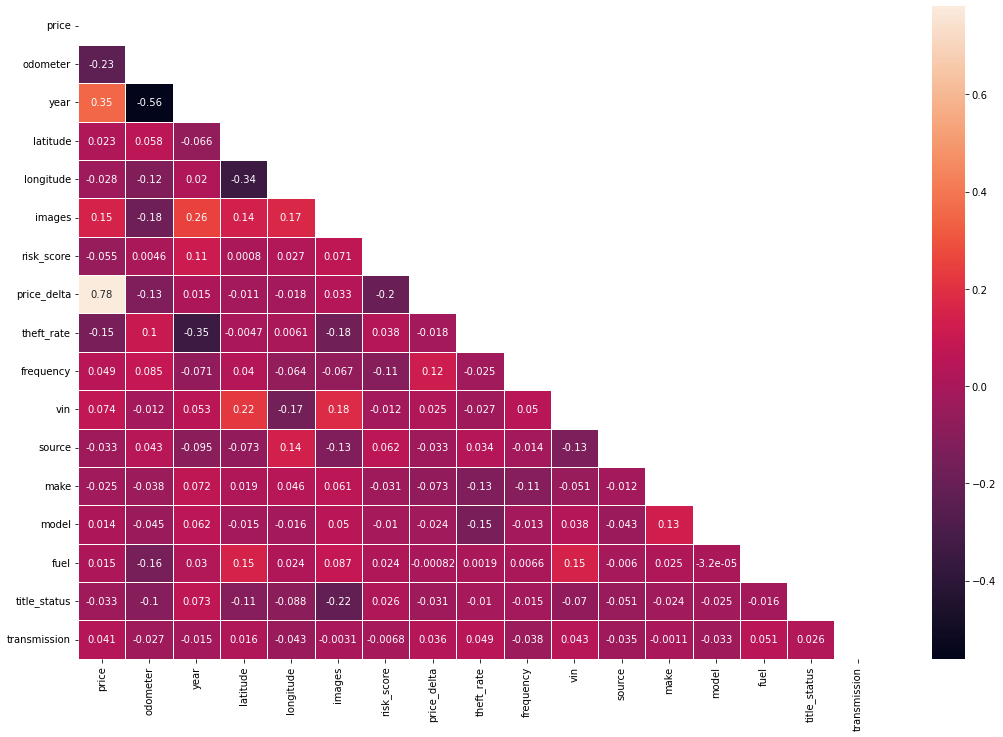

In [26]:

plt.figure(figsize = (18, 12))

corr = numeric_listings.corr()
mask = np.triu(np.ones_like(corr, dtype = bool))

sns.heatmap(data = corr, mask = mask, annot = True, fmt = '.2g', linewidth = 1)
plt.show()

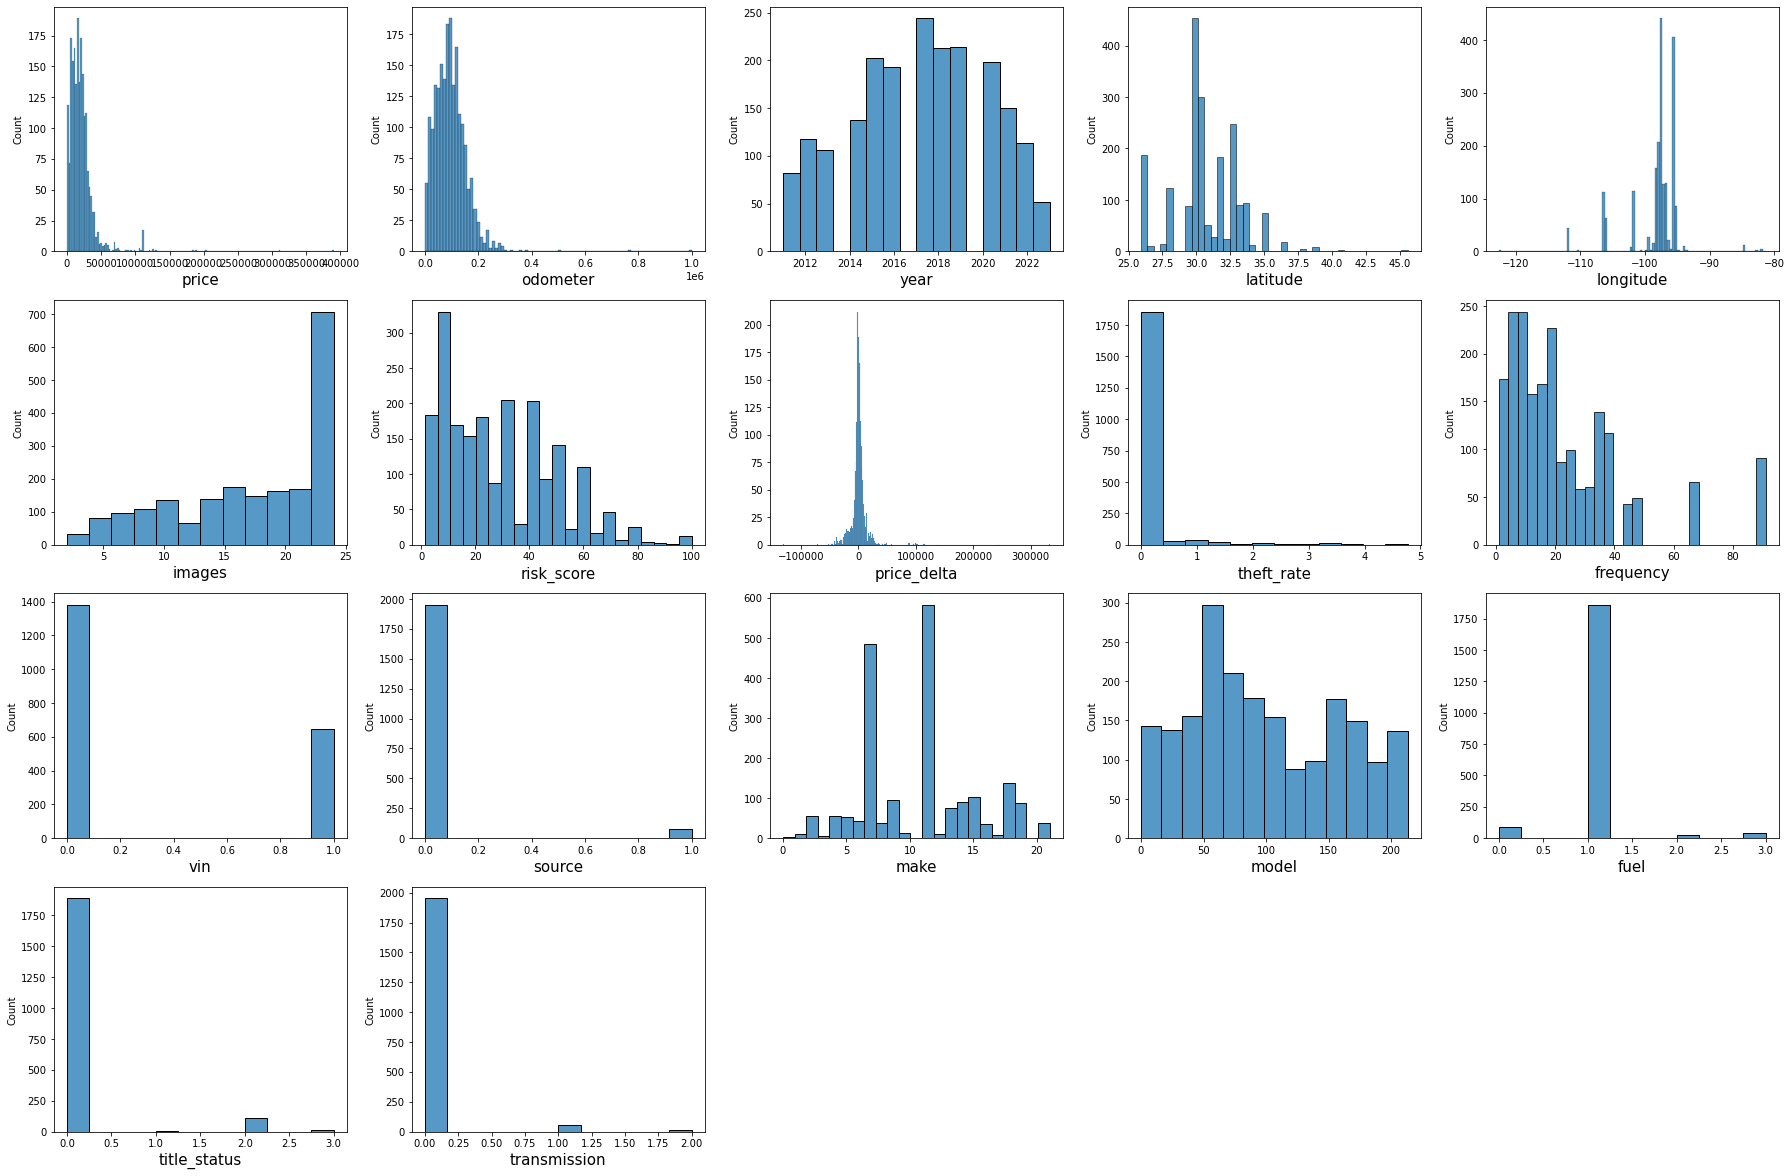

In [27]:
plt.figure(figsize = (25, 20))
plotnumber = 1

for col in numeric_listings.columns:
    ax = plt.subplot(5, 5, plotnumber)
    sns.histplot(numeric_listings[col])
    plt.xlabel(col, fontsize = 15)

    plotnumber += 1

plt.tight_layout()
plt.show()

### Outlier Detection

/Users/ryanlahlou/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/ryanlahlou/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/ryanlahlou/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretatio

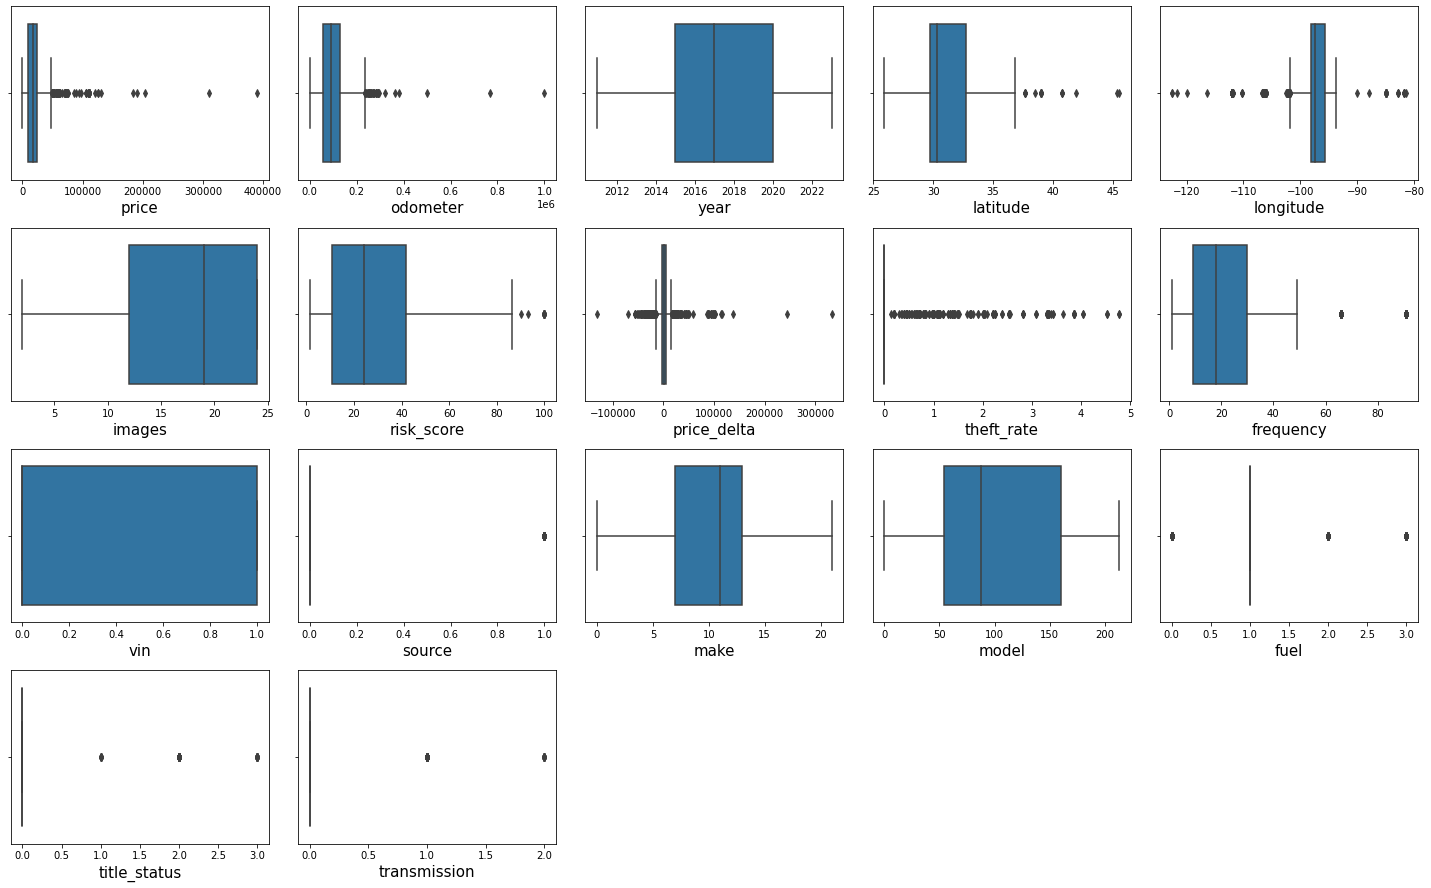

In [28]:
plt.figure(figsize = (20, 15))
plotnumber = 1

for col in numeric_listings.columns:
    if plotnumber <= 24:
        ax = plt.subplot(5, 5, plotnumber)
        sns.boxplot(numeric_listings[col])
        plt.xlabel(col, fontsize = 15)
    
    plotnumber += 1
plt.tight_layout()
plt.show()

In [29]:
cols_to_scale = numeric_listings[["price", "price_delta", "theft_rate", "frequency", "odometer", "year", "latitude", "longitude"]]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(cols_to_scale)

In [30]:
scaled_cols = pd.DataFrame(data = scaled_data, columns = cols_to_scale.columns, index = cols_to_scale.index)
scaled_cols.head()

,price,price_delta,theft_rate,frequency,odometer,year,latitude,longitude
0,-0.726985,-0.111667,-0.253257,-0.446961,0.518795,-1.950137,-1.832942,0.038768
1,-0.262184,-0.169265,-0.253257,-0.302297,-1.098435,0.928818,-1.822355,0.041220
2,-0.678009,-0.221098,5.612886,-0.302297,-0.092716,-0.990486,-1.822355,0.041220
3,-0.262184,-0.377952,-0.253257,-0.784512,-0.389485,0.289050,-1.822355,0.041220
5,-0.139819,0.050500,-0.253257,0.758578,0.045414,-0.350718,-1.796274,0.012262


/Users/ryanlahlou/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/ryanlahlou/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/ryanlahlou/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretatio

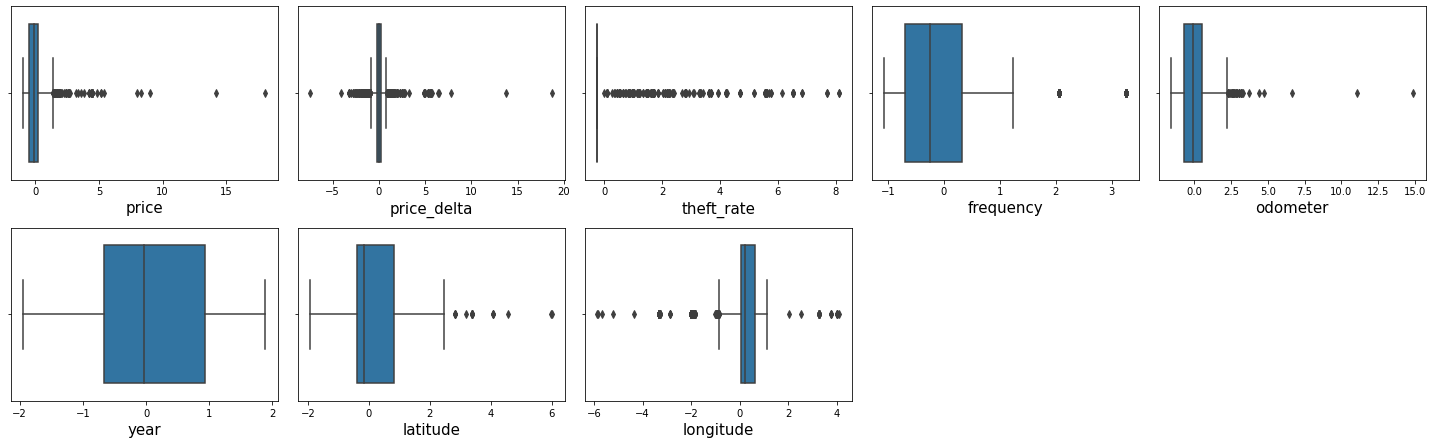

In [31]:
plt.figure(figsize = (20, 15))
plotnumber = 1

for col in scaled_cols.columns:
    if plotnumber <= 24:
        ax = plt.subplot(5, 5, plotnumber)
        sns.boxplot(scaled_cols[col])
        plt.xlabel(col, fontsize = 15)
    
    plotnumber += 1
plt.tight_layout()
plt.show()

In [32]:
numeric_listings = pd.concat([numeric_listings.drop(columns=scaled_cols.columns), scaled_cols], axis=1)

LinAlgError: singular matrix

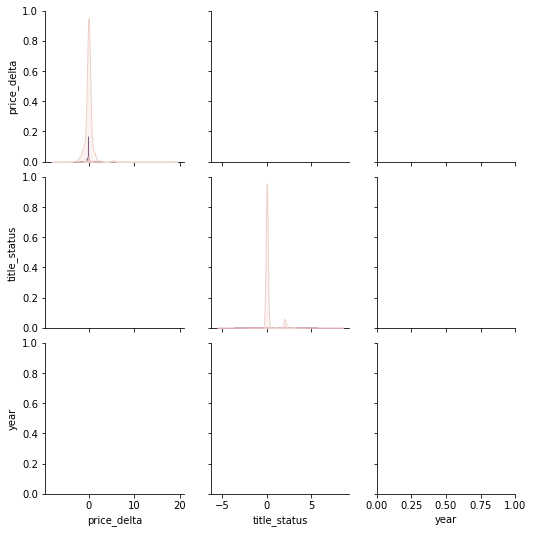

In [33]:
sns.pairplot(numeric_listings, vars = ["price_delta", "title_status", "year"], hue="theft_rate")

In [ ]:
X3 = numeric_listings.values
inertia = []

for n in range(1 , 11):
    algorithm = (KMeans(n_clusters = n, init='k-means++', n_init = 10, max_iter=300, 
                        tol=0.0001, random_state= 111, algorithm='lloyd'))
    algorithm.fit(X3)
    inertia.append(algorithm.inertia_)

In [ ]:
algorithm = (KMeans(n_clusters = 6 ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
algorithm.fit(X3)
labels3 = algorithm.labels_
centroids3 = algorithm.cluster_centers_

y_kmeans = algorithm.fit_predict(X3)
listings['cluster'] = pd.DataFrame(y_kmeans)
listings.head()